# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

c:\users\glukh\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


В следующий раз данные можно считывать уже из батчей:

In [6]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [118]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [119]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [120]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           dictionary='dictionary'), overwrite=True)
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"), overwrite=True)
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'), overwrite=True)
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"), overwrite=True)

In [121]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [122]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

c:\users\glukh\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


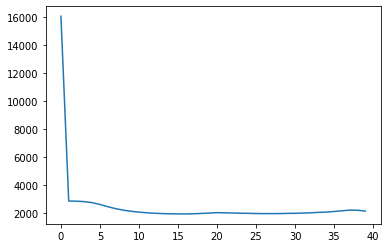

In [64]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [65]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end='\t'),
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print(word, end=' '),
    print()

sbj0: 	который быть что это человек этот как свой для они его весь такой время себя 
sbj1: 	возведение a b множитель раскладывать x выражение умножение скобка разложение сокращенный квадрат ответ переменный целый 
sbj2: 	обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот вера браслет старик сантьяго 
sbj3: 	который быть год свой время государство человек мир становиться северный жизнь первый война африка ребенок 
sbj4: 	x a b уравнение дробь квадратный y степень функция число f решение корень c пример 
sbj5: 	быть пушкин год функция свой его русский который поэт империя a культура весь f трение 
sbj6: 	сила быть тело энергия поле при магнитный точка географический наречие если частица например заряд величина 
sbj7: 	который что это как человек для этот такой быть являться мочь себя она его свой 
sbj8: 	который быть что это свой как этот человек для x они такой государство a весь 
sbj9: 	который быть что этот это как человек свой для т

Давайте посмотрим также на разреженность матриц:

In [66]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7333747148513794
0.1655462235212326


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [123]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-10, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

c:\users\glukh\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [124]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [69]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end='\t'),
    tokens = model_artm.score_tracker["top_words"].last_tokens.items()
    for word in tokens[topic_name]:    
        print(word, end=' '),
    print()

c:\users\glukh\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sbj0: 	

TypeError: 'dict_items' object is not subscriptable

In [125]:
for i,j in model_artm.score_tracker["top_words"].last_tokens.items():
    print(i, j)

sbj0 ['который', 'быть', 'что', 'это', 'этот', 'как', 'человек', 'свой', 'для', 'они', 'весь', 'такой', 'его', 'время', 'год']
sbj2 ['обособление', 'куприн', 'слово', 'раскольников', 'мастер', 'роман', 'словосочетание', 'маргарита', 'браслет', 'соня', 'вера', 'управление', 'зависимое', 'княгиня', 'теория']
sbj3 ['который', 'быть', 'для', 'год', 'что', 'этот', 'как', 'это', 'свой', 'весь', 'они', 'человек', 'государство', 'такой', 'время']
sbj4 ['x', 'a', 'b', 'число', 'уравнение', 'корень', 'функция', 'дробь', 'y', 'квадратный', 'степень', 'f', 'решение', 'получать', 'пример']
sbj5 ['быть', 'функция', 'пушкин', 'точка', 'трение', 'a', 'f', 'год', 'предложение', 'империя', 'существительное', 'звук', 'пример', 'язык', 'падеж']
sbj6 ['магнитный', 'индукция', 'подчинительный', 'наречие', 'примыкать', 'глагол', 'местоимение', 'поле', 'прилагательное', 'прилагательный', 'разряд', 'существительный', 'например', 'оборот', 'генератор']
sbj7 ['что', 'человек', 'это', 'его', 'свой', 'как', 'она',

c:\users\glukh\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [126]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8120690584182739
0.31617647409439087


Попробуем менять коэффициент регуляризации:

In [127]:
model_artm.regularizers['SparsePhi'].tau = -3*1e3

In [ ]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

In [ ]:
for i,j in model_artm.score_tracker["top_words"].last_tokens.items():
    print(i, j)

In [ ]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [ ]:
model_artm.save("my_model")

In [ ]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [78]:
phi = model_artm.get_phi()

In [79]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
"(text, домохозяйка)",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000011
"(text, институт)",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.001467,0.000000
"(text, машинка)",0.0,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.000000,0.000000
"(text, прочий)",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000090
"(text, навязнуть)",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000577,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
"(text, задабривать)",0.0,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.000000,0.000000
"(text, шаманский)",0.0,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.000000,0.000000
"(text, усопший)",0.0,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.000000,0.000000
"(text, рисование)",0.0,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.000000,0.000000


Матрица вероятностей тем в документах.

In [50]:
theta = model_artm.get_theta()
theta

,201,202,203,204,205,206,207,208,209,210,...,91,92,93,94,95,96,97,98,99,100
sbj0,0.000000,0.0,0.000000,0.025641,0.0,0.005495,1.282051e-02,0.007012,0.015306,0.016878,...,0.0,0.000000,0.000000,0.000000,0.004566,0.000000,0.000000,1.065346e-16,0.009944,0.020492
sbj1,0.004695,0.0,0.000000,0.005128,0.0,0.000000,2.326925e-09,0.071799,0.025636,0.025316,...,0.0,0.000000,0.000000,0.013393,0.305687,0.000000,0.309735,7.356615e-03,0.066667,0.479444
sbj2,0.061033,0.0,0.027053,0.035897,0.0,0.093407,4.273504e-02,0.041958,0.041297,0.017794,...,1.0,0.013451,0.341317,0.000000,0.000000,0.144444,0.017699,6.179777e-02,0.318133,0.049180
sbj3,0.652196,0.0,0.008969,0.020513,0.0,0.030890,2.564103e-02,0.017791,0.072254,0.000000,...,0.0,0.174107,0.000000,0.000000,0.000000,0.593818,0.000000,1.966293e-01,0.015045,0.000000
sbj4,0.000000,0.0,0.004484,0.000000,0.0,0.016905,9.110670e-03,0.020979,0.425943,0.000000,...,0.0,0.000000,0.000000,0.000000,0.013948,0.000000,0.022124,4.757892e-01,0.010018,0.000000
sbj5,0.282076,1.0,0.851805,0.046154,1.0,0.740760,7.264958e-02,0.061090,0.000000,0.039157,...,0.0,0.031250,0.658683,0.000000,0.000000,0.261737,0.017699,1.629214e-01,0.075431,0.000000
sbj6,0.000000,0.0,0.053812,0.148718,0.0,0.041114,2.173850e-01,0.160897,0.292013,0.063291,...,0.0,0.000000,0.000000,0.120536,0.602739,0.000000,0.314159,9.550567e-02,0.366667,0.286949
sbj7,0.000000,0.0,0.009034,0.497436,0.0,0.043956,8.974358e-02,0.499593,0.000000,0.042194,...,0.0,0.071429,0.000000,0.674107,0.073059,0.000000,0.106195,0.000000e+00,0.033333,0.073771
sbj8,0.000000,0.0,0.013453,0.148718,0.0,0.005495,2.905983e-01,0.000000,0.040816,0.315539,...,0.0,0.709763,0.000000,0.000000,0.000000,0.000000,0.048673,0.000000e+00,0.014286,0.000000
sbj9,0.000000,0.0,0.031390,0.071795,0.0,0.021978,2.393163e-01,0.118881,0.086735,0.479830,...,0.0,0.000000,0.000000,0.191964,0.000000,0.000000,0.163717,0.000000e+00,0.090476,0.090164


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [28]:
theta_test = model_artm.transform(batch_vectorizer)